In [1]:
#imports 
import astropy.units as u
import numpy as np
import popsims #custom libray for plotting aesthetics
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm

#import HSS
import seaborn as sns
import matplotlib as mpl

import astropy.coordinates as astro_coord
import glob
import pandas as pd
#sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'size'   : 20}


import itertools
from scipy import stats
from shapey import Box
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
#path_data = '/users/caganze/research/stellarstreams/data/rotating/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


In [372]:
plt.style.use('dark_background') #for posters


In [370]:
#read file
def read_gap_detection_results(mhalo, galaxy, rgc, mag_limit, dmod):
    file_prefix='gaps_rescaled_at_{}{}_mlimit_{}Mhalo={:.2e}_dmod{:.2f}'.format(galaxy, rgc, mag_limit, mhalo, dmod)
    filename=file_prefix+'analysis_results' 
    
    return np.load(path_data+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0]

def get_snr(mhalo, galaxy, rgc, mag_limit, dmod):
    data=read_gap_detection_results(mhalo, galaxy, rgc, mag_limit, dmod)
    #/np.nanmedian(np.nanmedian(data['stream_density_out']))
    nstream= np.nanmedian(data['stream_density_along_grid'])
    ngap= np.nanmedian(data['gap_stars'])
    
    #compute std
    return (nstream-ngap)/nstream

    
def show_gap_detection(all_res, ax, threshold=97. ):
    res= all_res['gappy_res']
    gap_bw= all_res['gap_bw']
    meshgrid= res[gap_bw]['meshgrid']
    stream_bw= all_res['stream_bw']
    data=res[stream_bw]['data']
    
    gap_mask = res[gap_bw]['max_eigen'] > np.percentile(res[gap_bw]['max_eigen'],threshold ) 


    ax.contour(meshgrid[0], meshgrid[1],  res[gap_bw]['density'],  20, \
                      cmap='spring', alpha=.5)
    p= ax.contourf(meshgrid[0], meshgrid[1], res[gap_bw]['max_eigen'],\
                            20, cmap='afmhot',  vmin=0., vmax=1)
    plt.colorbar(p, label=r'Max Eigenvalue of $\Pi H \Pi$', ax=ax)
    ax.scatter(data[:,0], data[:,1], s=10, alpha=0.1, c='#2ECC40')

    ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
    plt.minorticks_on()
    

def compute_gap_location (mhalo, galaxy, rgc, mag_limit, dmod, threshold=97.):
    
    all_res=read_gap_detection_results(mhalo, galaxy, rgc, mag_limit, dmod)
    loc=all_res['gap_loc']
    std= all_res['gap_size']

    res=res= all_res['gappy_res']
    gap_mask=all_res['gap_mask']
    stream_mask=all_res['stream_mask']
    
    gap_bw= all_res['gap_bw']
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in  res[gap_bw]['meshgrid']]
    
    grid_data = np.hstack(meshgrid_ravel)
    
    gap_mask = res[gap_bw]['max_eigen'] > np.percentile(res[gap_bw]['max_eigen'],threshold ) 
    
    #compute gap location
    loc=(np.nanmedian(grid_data[:,0][gap_mask.flatten().astype(bool)]),
        np.nanmedian(grid_data[:,1][gap_mask.flatten().astype(bool)]))
    
   
    selected= grid_data[:,0][gap_mask.flatten().astype(bool)]
    
    uncs=[]
    for idx in range(0, 1000):
        chosen=np.nanstd(np.random.choice(selected, 1000, replace=True))#/gap_bw
        uncs.append(chosen)
    return loc, [np.nanmedian(uncs), np.nanstd(uncs)]

    

def show_stream_detection(all_res, ax):
    res= all_res['gappy_res']
    stream_bw= all_res['stream_bw']
    meshgrid= res[stream_bw]['meshgrid']
    data=res[stream_bw]['data']

    ax.contour(meshgrid[0], meshgrid[1],  res[stream_bw]['density'],  20, \
                      cmap='spring', alpha=.5)

    #cax = fig.add_axes([1.01, 0.6, .02, 0.3])
    p= ax.contourf(meshgrid[0], meshgrid[1], res[stream_bw]['max_eigen'],\
                            20, cmap='afmhot', vmin=0., vmax=1)
    plt.colorbar(p, label=r'Mim Eigenvalue of $\Pi H \Pi$', ax=ax)
    #ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
    
    ax.scatter(data[:,0], data[:,1], s=10, alpha=1., c='k')
    #c=ax.contourf( meshgrid[0], meshgrid[1], np.array(res[stream_bw]['density']),  20, \
    #                  cmap='cividis', alpha=.5)
    #cax = fig.add_axes([1.01, 0.6, .02, 0.3])
    #plt.colorbar(c, label='Density', ax=ax)
    ax.contour(meshgrid[0], meshgrid[1],  res[stream_bw]['density'],  20, \
                      cmap='spring', alpha=.5)
    ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
    plt.minorticks_on()

In [4]:
mhalos=[2e6, 5e6]
galaxy='OTHER'
rgc='50_60'
d=([0.5, 0.77, 1.0, 1.5, 2.0, 2.5 ])*u.Mpc
dmods=5*np.log10(d.to(u.pc)/(10*u.pc)).value
mlimit=28.54

In [5]:
import matplotlib.ticker as ticker

In [6]:
all_ds=([0.5, 0.6, 0.77, 0.8, 0.9, 1.0, 1.3, 1.5, 1.6, 1.7, 2., 2.5, 3., 3.5, 4., 4.5, 5.])*u.Mpc
all_dmods=5*np.log10(all_ds.to(u.pc)/(10*u.pc)).value

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


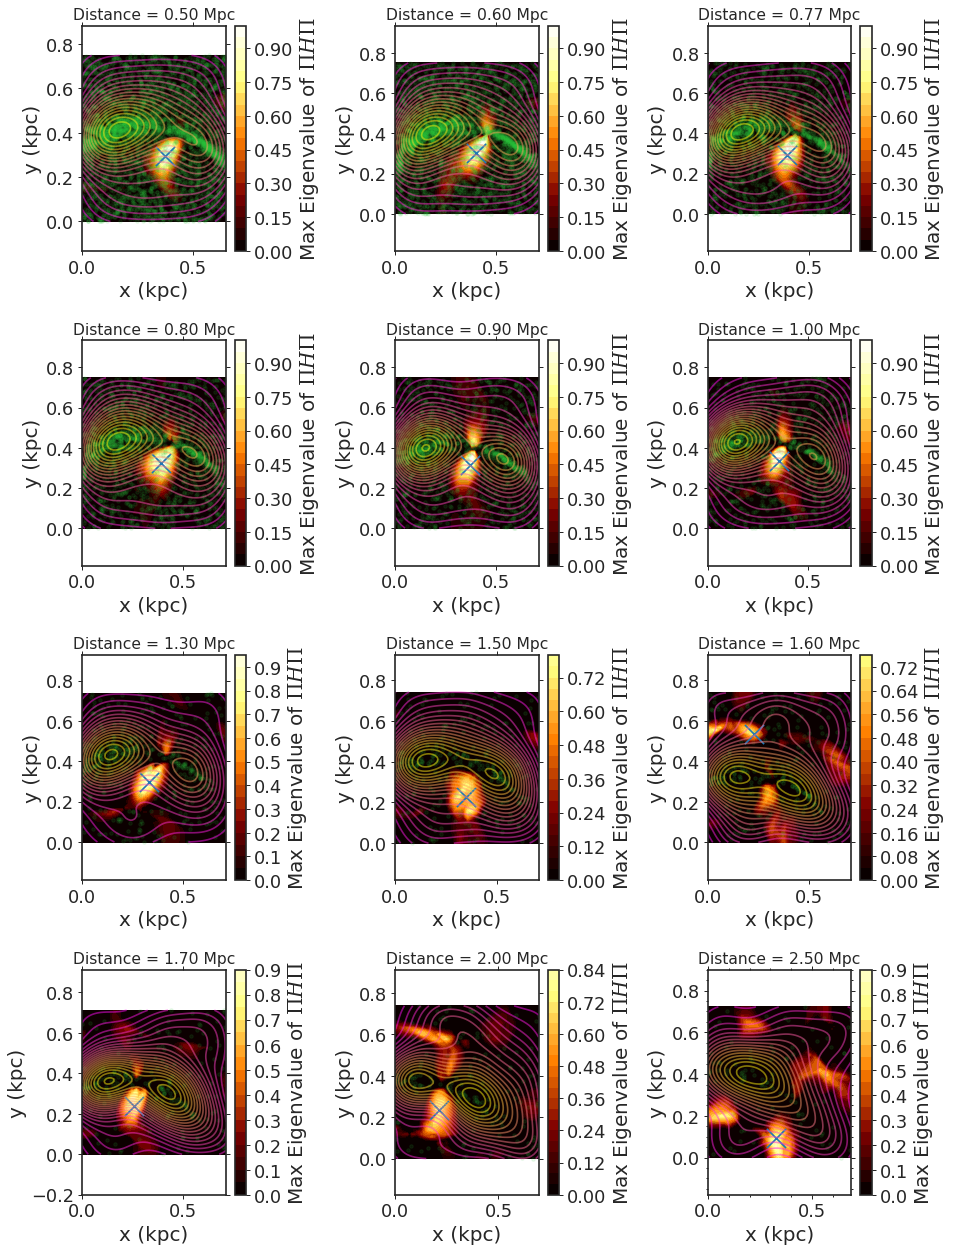

In [7]:
figname=path_plot+'/gaps_location_piHpi.jpeg'

fig, ax=plt.subplots(figsize=(12, 4*4), ncols=3, nrows=4)

for idx in range(0, 12):
    a= np.concatenate(ax)[idx]
    dmod= all_dmods[idx]
    
    res=read_gap_detection_results(5e6, galaxy, rgc, 28.54, dmod)
    
    loc, std= compute_gap_location (5e6, galaxy, rgc, 28.54, dmod)
    
    show_gap_detection(res,a )
    a.scatter(loc[0], loc[1], marker='x', s=300)
    
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Distance = {:.2f} Mpc '.format(  d_M31), fontsize=14)
    a.axis('equal')
    
plt.tight_layout()
plt.savefig(figname)

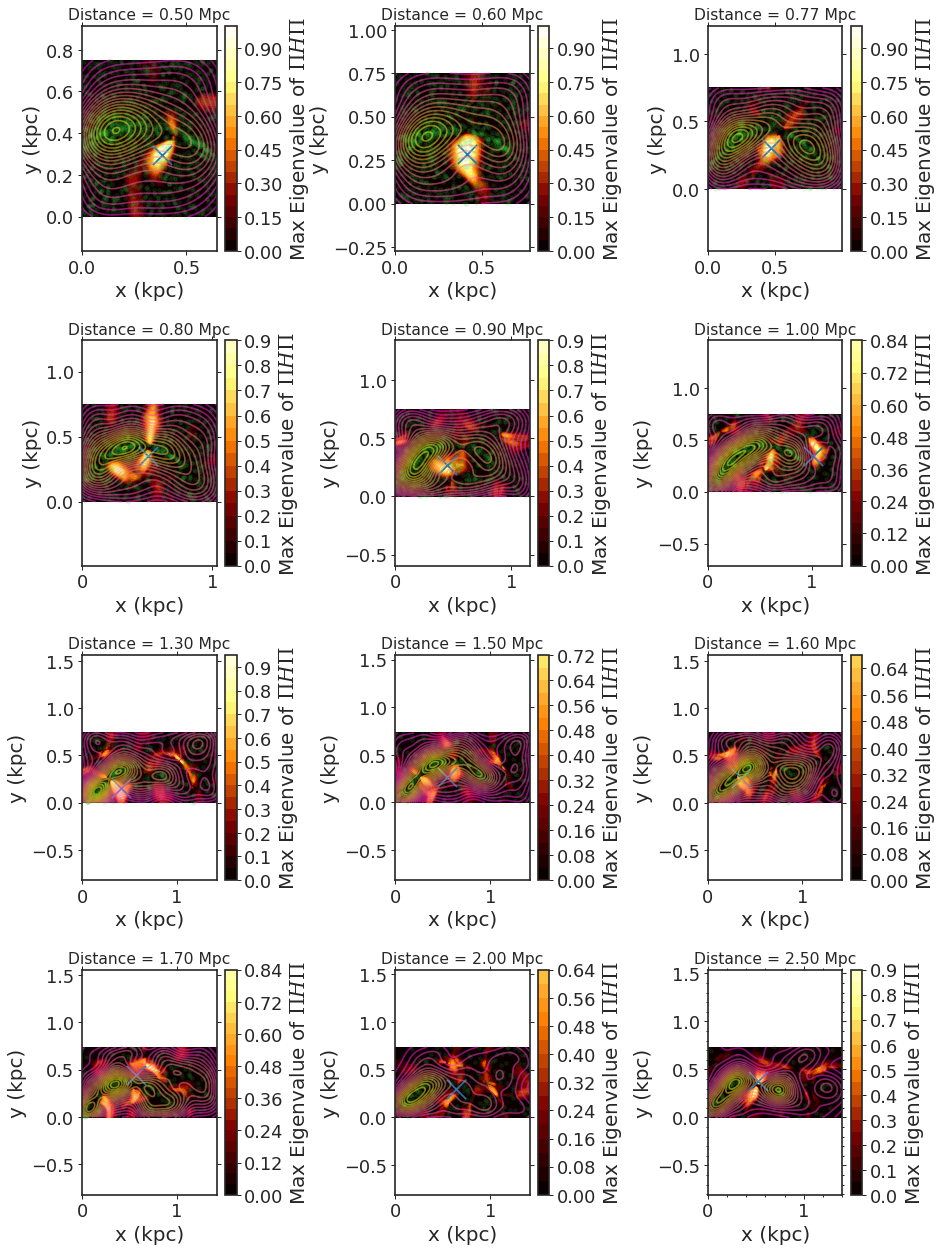

In [8]:
figname=path_plot+'/gaps_location_piHpi.jpeg'

fig, ax=plt.subplots(figsize=(12, 4*4), ncols=3, nrows=4)

for idx in range(0, 12):
    a= np.concatenate(ax)[idx]
    dmod= all_dmods[idx]
    
    res=read_gap_detection_results(mhalos[-1], galaxy, rgc, 27.15, dmod)
    
    loc, std= compute_gap_location (mhalos[-1], galaxy, rgc, 27.15, dmod)
    
    show_gap_detection(res,a )
    a.scatter(loc[0], loc[1], marker='x', s=300)
    
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Distance = {:.2f} Mpc '.format(  d_M31), fontsize=14)
    a.axis('equal')
    
plt.tight_layout()
plt.savefig(figname)

In [9]:
#figname


In [10]:
all_ds=([0.5, 0.6, 0.77, 0.8, 0.9, 1.0, 1.3, 1.5, 1.6, 1.7, 2., 2.5, 3., 3.5, 4., 4.5, 5.])*u.Mpc
all_dmods=5*np.log10(all_ds.to(u.pc)/(10*u.pc)).value


In [11]:
from matplotlib.ticker import ScalarFormatter


In [12]:
#1000s 
NUM_STARS=pd.read_pickle(isochrone_path+'/number_of_stars_pal5.pkl')

In [13]:
NUM_STARS

{'mlimit27.15 dmod21.51': 4368.950719731283,
 'mlimit28.54 dmod21.51': 7444.2163489465065,
 'mlimit27.15 dmod23.49': 872.1178564366224,
 'mlimit28.54 dmod23.49': 3074.0684460887946,
 'mlimit27.15 dmod23.89': 530.6226528814502,
 'mlimit28.54 dmod23.89': 2281.4521713324757,
 'mlimit27.15 dmod24.43': 272.412724984018,
 'mlimit28.54 dmod24.43': 1413.1530569886734,
 'mlimit27.15 dmod24.52': 246.31361978753765,
 'mlimit28.54 dmod24.52': 1304.1823345341713,
 'mlimit27.15 dmod24.77': 198.23353648102565,
 'mlimit28.54 dmod24.77': 995.5722430449242,
 'mlimit27.15 dmod25.00': 175.6493078444298,
 'mlimit28.54 dmod25.00': 759.735895307002,
 'mlimit27.15 dmod25.57': 128.45418316213124,
 'mlimit28.54 dmod25.57': 359.8015378837296,
 'mlimit27.15 dmod25.88': 112.55845905884217,
 'mlimit28.54 dmod25.88': 255.12918433458876,
 'mlimit27.15 dmod26.02': 101.69659885568977,
 'mlimit28.54 dmod26.02': 218.55594389544984,
 'mlimit27.15 dmod26.15': 99.1501976284585,
 'mlimit28.54 dmod26.15': 197.14133206808614,


In [14]:
#all_dmods

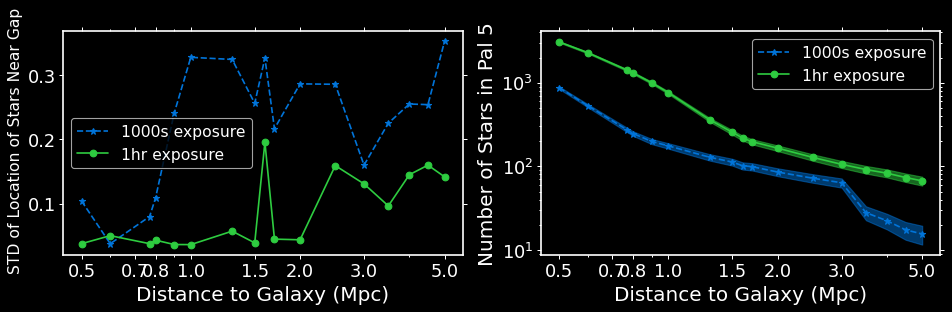

In [382]:
fig, (ax, ax1) =plt.subplots(ncols=2, figsize=(12, 4))

locs=[]
stds=[]
nstars=[]
for dmod in all_dmods:

    loc2, std2= compute_gap_location (mhalos[-1], galaxy, rgc, 27.15, dmod, threshold=95.)
    loc4, std4= compute_gap_location (mhalos[-1], galaxy, rgc, 28.54, dmod, threshold=95.)
    
    locs.append([ loc2[0], loc4[0]])
    stds.append([*std2,  *std4])
    
    #compute number of stars
    k='mlimit{:.2f} dmod{:.2f}'.format(27.15, dmod)
    k2= 'mlimit{:.2f} dmod{:.2f}'.format(28.54, dmod)
    nstars.append([NUM_STARS[k], NUM_STARS[k2]])
    
    
    
ax.errorbar(all_ds.value,  np.vstack(stds)[:,0], fmt ='--*',\
            label='1000s exposure', color='#0074D9')
ax.errorbar(all_ds.value,  np.vstack(stds)[:,2], fmt ='-o',\
            label='1hr exposure', color='#2ECC40')

ax1.plot( all_ds.value, np.vstack( nstars)[:,0], '--*', color='#0074D9',  label='1000s exposure')
#ax1.scatter( all_ds.value,  np.vstack( nstars)[:,0], color='#0074D9')
ax1.fill_between( all_ds.value,  np.vstack( nstars)[:,0]-np.sqrt( np.vstack( nstars)[:,0]),  \
                  np.vstack( nstars)[:,0]+np.sqrt( np.vstack( nstars)[:,0]), \
                    color='#0074D9', alpha=0.5)

    
ax1.plot( all_ds.value, np.vstack( nstars)[:,1], '-o', color='#2ECC40',  label='1hr exposure')
#ax1.scatter( all_ds.value,  np.vstack( nstars)[:,1], color='#FF4136')
ax1.fill_between( all_ds.value,  np.vstack( nstars)[:,1]-np.sqrt( np.vstack( nstars)[:,1]),  \
                  np.vstack( nstars)[:,1]+np.sqrt( np.vstack( nstars)[:,1]), \
                    color='#2ECC40', alpha=0.5 )

for a in [ax, ax1]:

    a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    #ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
    a.tick_params(bottom=True, left=True)
    #ax.set(ylim=[-0.1, 1.3])
    a.legend(fontsize=19)
    a.set(xlabel='Distance to Galaxy (Mpc)', xscale='log')
    
    a.set_xticks([0.5, 0.7, 0.8, 1., 1.5, 2., 3, 5])
    a.get_xaxis().set_major_formatter(ScalarFormatter())
    

plt.tight_layout()
ax1.legend(fontsize=14)
ax.legend(fontsize=14)

ax.set_ylabel(r' STD of Location of Stars Near Gap', fontsize=14)
ax1.set(ylabel=r'Number of Stars in Pal 5', yscale='log')

plt.savefig(path_plot+'/gaps_location_error.jpeg')


In [16]:
#try this for different masses
stds={}

stds={}
for m in [2e6, 5e6, 1e7]:
    vals=[]
    for dmod in all_dmods:
        _, std1= compute_gap_location (m, galaxy, rgc, 27.15, dmod, threshold=95.)
        _, std2= compute_gap_location (m, galaxy, rgc, 28.54, dmod, threshold=95.)
        vals.append([std1, std2])
    stds.update({'{:.2e}'.format(m): vals})

In [17]:
np.shape(np.array(stds['2.00e+06'])[:,0])

(17, 2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


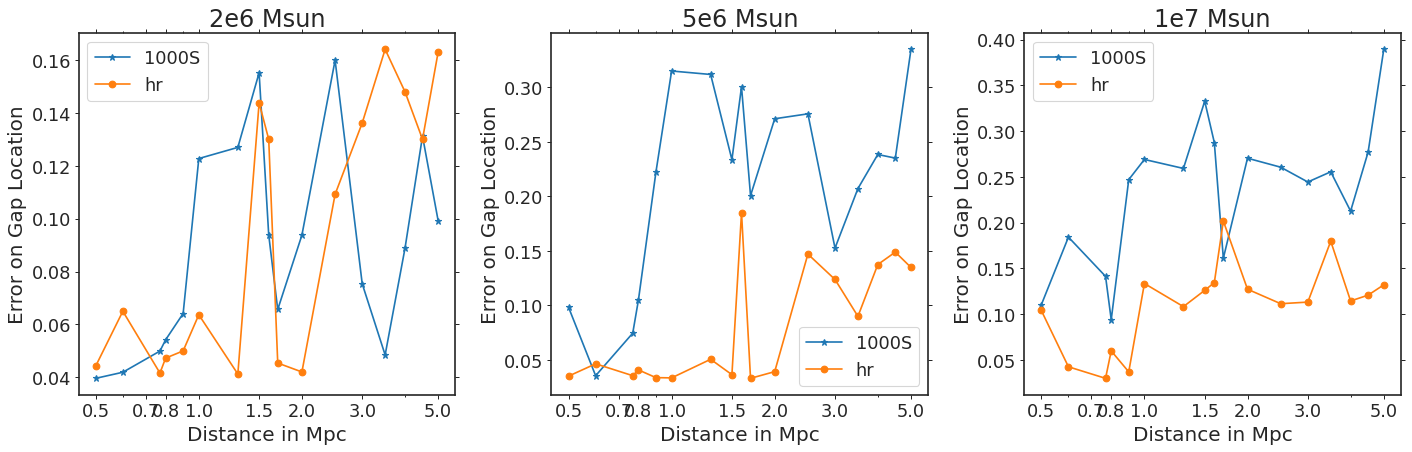

In [18]:
fig, ax=plt.subplots(figsize=(12*1.5, 4*1.5 ), ncols=3)

vals= np.array(stds['2.00e+06'])[:,0]
ax[0].errorbar(all_ds.value, vals[:,0], fmt='*-', label='1000S')
vals= np.array(stds['2.00e+06'])[:,1]
ax[0].errorbar(all_ds.value, vals[:,0], fmt='o-', label='hr')
ax[0].set(xlabel='Distance in Mpc', ylabel='Error on Gap Location')

vals= np.array(stds['5.00e+06'])[:,0]
ax[1].errorbar(all_ds.value, vals[:,0], fmt='*-', label='1000S')
vals= np.array(stds['5.00e+06'])[:,1]
ax[1].errorbar(all_ds.value, vals[:,0], fmt='o-', label='hr')
ax[1].set(xlabel='Distance in Mpc', ylabel='Error on Gap Location')

vals= np.array(stds['1.00e+07'])[:,0]
ax[-1].errorbar(all_ds.value, vals[:,0], fmt='*-', label='1000S')
vals= np.array(stds['1.00e+07'])[:,1]
ax[-1].errorbar(all_ds.value, vals[:,0], fmt='o-', label='hr')
ax[-1].set(xlabel='Distance in Mpc', ylabel='Error on Gap Location')


ax[0].set(title='2e6 Msun')
ax[1].set(title='5e6 Msun')
ax[-1].set(title='1e7 Msun')

for a in ax:
    a.legend(fontsize=16)
    a.set(xscale='log')
    a.set_xticks([0.5, 0.7, 0.8, 1., 1.5, 2., 3, 5])
    a.get_xaxis().set_major_formatter(ScalarFormatter())
plt.tight_layout()

In [19]:
def compute_snr_location (mhalo, galaxy, rgc, mag_limit, dmod, threshold=97.):
    
    all_res=read_gap_detection_results(mhalo, galaxy, rgc, mag_limit, dmod)
    loc=all_res['gap_loc']
    std= all_res['gap_size']

    res=res= all_res['gappy_res']
    gap_mask=all_res['gap_mask']
    stream_mask=all_res['stream_mask']
    
    gap_bw= all_res['gap_bw']
    stream_bw= all_res['stream_bw']
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in  res[gap_bw]['meshgrid']]
    
    grid_data = np.hstack(meshgrid_ravel)
    
    gap_mask = res[gap_bw]['max_eigen'] > np.percentile(res[gap_bw]['max_eigen'],threshold ) 
    
    stream_mask = res[stream_bw]['max_eigen'] < np.percentile(res[stream_bw]['max_eigen'], 1. ) 
    
    density= res[stream_bw]['density']
    
    #compute gap location
    gap=density[gap_mask.astype(bool)]
    
    #stream
    stream= density[stream_mask.astype(bool)]
    
    #bckgd
    bck= density[~stream_mask.astype(bool)]
   
    return {'gap': (np.nanmedian(gap),np.nanstd(gap)),
            'stream': (np.nanmedian(stream), np.nanstd(stream)), \
            'bck': (np.nanmedian(bck), np.nanstd(bck))}

In [20]:
compute_snr_location (mhalos[-1], galaxy, rgc, 28.54, dmod, threshold=95.)

{'gap': (0.42183325, 0.29212046),
 'stream': (6.014991, 0.46401274),
 'bck': (0.7794349, 1.225552)}

In [21]:
res= []
for dmod in dmods:
    res.append(compute_snr_location (mhalos[-1], galaxy, rgc, 28.54, dmod, threshold=99.))

In [22]:
pd.DataFrame.from_records(res)

,gap,stream,bck
0,"(1.870074, 0.16555859)","(3.0482645, 0.16991386)","(1.3619221, 0.66318625)"
1,"(1.809544, 0.1933407)","(3.045282, 0.20700242)","(1.1975329, 0.6789649)"
2,"(1.9481502, 0.15969601)","(3.0878856, 0.22213478)","(1.2431662, 0.6560446)"
3,"(1.8761199, 0.31725207)","(2.7238822, 0.22126591)","(1.2533312, 0.7479165)"
4,"(1.4984634, 0.3806537)","(2.5725398, 0.24676205)","(1.2715286, 0.65147316)"
5,"(0.80245143, 0.23024005)","(3.2645018, 0.21917532)","(1.2313515, 0.7713981)"


In [ ]:
#kathryn's methods
#run gappy on streams 10 different distances, different bandwidths -> done
# compute do polyfit for all 10
#n stars = density * bandwith
#n gap = density*bandwith
#save the maximum contrast

In [28]:
#read file
def read_kath_detection_results(mhalo, galaxy, rgc, mag_limit, dmod):
    file_prefix='gaps_rescaled_at_{}{}_mlimit_{}Mhalo={:.2e}_dmod{:.2f}'.format(galaxy, rgc, mag_limit, mhalo, dmod)
    filename=file_prefix+'analysis_results_morebandwidths' 
    
    return np.load(path_data+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0]


In [285]:
def compute_gap_location_new(res, threshold=97):
    
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in  res['meshgrid']]
    
    grid_data = np.hstack(meshgrid_ravel)
    
    gap_mask = res['max_eigen'] > np.percentile(res['max_eigen'],threshold ) 
    
    #compute gap location
    loc=(np.nanmedian(grid_data[:,0][gap_mask.flatten().astype(bool)]),
        np.nanmedian(grid_data[:,1][gap_mask.flatten().astype(bool)]))
   
    selected= grid_data[:,0][gap_mask.flatten().astype(bool)]
    
    return loc, np.nanstd(selected)

def fit_pol(res):
    meshgrid= resx['meshgrid']
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in  meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    gap_mask = resx['max_eigen'] > np.percentile(resx['max_eigen'], 95)
    stream_mask = resx['min_eigen'] < np.percentile(resx['min_eigen'], 5)
    
    #make a fit to the density
    x=grid_data[:,0][stream_mask.flatten().astype(bool)]
    y=grid_data[:,1][stream_mask.flatten().astype(bool)]
    
    #x[-1]=gap_loc[0]
    #y[-1]=gap_loc[1]
    pol= np.poly1d(np.polyfit(x, y, 2))
    
    fig, ax=plt.subplots()
    
    ax.scatter( resx['data'][:,0],  resx['data'][:,1], s=1, color='k')
    ax.scatter(grid_data[:,0][gap_mask.flatten().astype(bool)], \
                grid_data[:,1][gap_mask.flatten().astype(bool)], s=50,\
                marker='+', c='#0074D9')
    ax.scatter(grid_data[:,0][stream_mask.flatten().astype(bool)], \
                grid_data[:,1][stream_mask.flatten().astype(bool)], s=50,\
                marker='+', c='#FF851B')
    
    stdy= np.nanstd( grid_data[:,1][stream_mask.flatten().astype(bool)])
    ax.plot(grid_data[:,0], pol(grid_data[:,0])-stdy, linewidth=3, c='#0074D9')
    ax.plot(grid_data[:,0], pol(grid_data[:,0])+stdy, linewidth=3, c='#0074D9')
    
    #compute density inside polynomial bin
    
    return pol
    

def diagnostic_plots_one_stream(resx):
    fig, (ax, ax1, ax2)=plt.subplots(ncols=3, figsize=(12, 4))

    meshgrid= resx['meshgrid']
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in  meshgrid]
    grid_data = np.hstack(meshgrid_ravel)

    #max
    ax.contour(meshgrid[0], meshgrid[1],  resx['density'],  20, \
                      cmap='spring', alpha=.5)

    cax = fig.add_axes([0.08, 0., .3, 0.04])
    p= ax.contourf(meshgrid[0], meshgrid[1], resx['max_eigen'],\
                            20, cmap='afmhot', vmin=0., vmax=1)
    plt.colorbar(p, ax=ax, cax=cax, orientation='horizontal')
    cax.set(xlabel=r'Max Eigenvalue of $\Pi H \Pi$')
    

    #min

    cax = fig.add_axes([0.4, 0., .3, 0.04])
    ax1.contour(meshgrid[0], meshgrid[1],  resx['density'],  20, \
                      cmap='spring', alpha=.5)
    p= ax1.contourf(meshgrid[0], meshgrid[1], resx['min_eigen'],\
                            20, cmap='cubehelix', vmin=0., vmax=1)
    plt.colorbar(p,  ax=ax1, cax=cax, orientation='horizontal')
    cax.set(xlabel=r'Min Eigenvalue of $\Pi H \Pi$')


    gap_mask = resx['max_eigen'] > np.percentile(resx['max_eigen'], 95)
    stream_mask = resx['min_eigen'] < np.percentile(resx['min_eigen'], 5)
    ax2.scatter( resx['data'][:,0],  resx['data'][:,1], s=1, color='k')
    ax2.scatter(grid_data[:,0][gap_mask.flatten().astype(bool)], \
                grid_data[:,1][gap_mask.flatten().astype(bool)], s=50,\
                marker='+', c='#0074D9')
    ax2.scatter(grid_data[:,0][stream_mask.flatten().astype(bool)], \
                grid_data[:,1][stream_mask.flatten().astype(bool)], s=50,\
                marker='+', c='#FF851B')

    for a in [ax, ax1, ax2]:
        a.set(xlabel='Scaled y (kpc) ', ylabel='Scaled y (kpc) ', )
        a.axis('equal')
    plt.tight_layout()
    plt.savefig(path_plot+'//stream_cutout_gap_rescaled.jpeg', bbox_inches='tight')


def pipeline_with_polynomial_fit(resx):
    passs
    

In [352]:
all_dmods

array([23.49485002, 23.89075625, 24.43245363, 24.51544993, 24.77121255,
       25.        , 25.56971676, 25.8804563 , 26.02059991, 26.15224461,
       26.50514998, 26.98970004, 27.38560627, 27.72034022, 28.01029996,
       28.26606257, 28.49485002])

In [363]:
res=read_kath_detection_results(5e6, galaxy, rgc, 28.54, 26.51)

In [364]:
list(res.keys())

[0.01,
 0.11642857142857142,
 0.22285714285714286,
 0.3292857142857143,
 0.4357142857142857,
 0.5421428571428571,
 0.6485714285714286,
 0.755,
 0.8614285714285714,
 0.9678571428571429,
 1.0742857142857143,
 1.1807142857142858,
 1.2871428571428571,
 1.3935714285714285,
 1.5]

In [383]:
resx=res[list(res.keys())[-1]][list(res.keys())[-1]]

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_46892/393990257.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


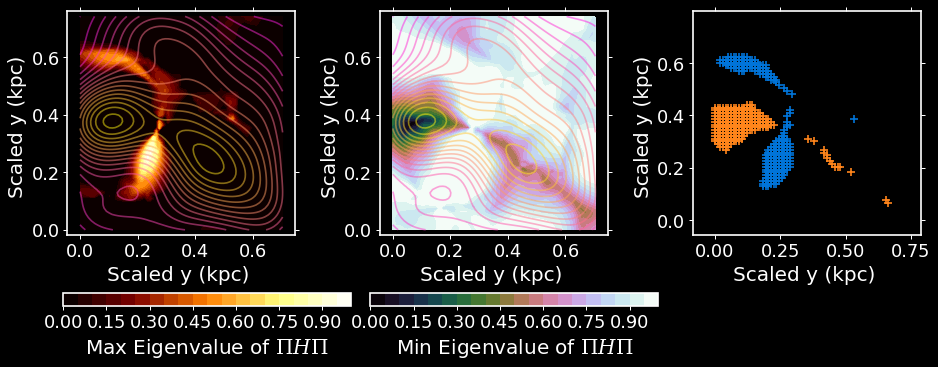

In [384]:
#for bw in res.keys():
diagnostic_plots_one_stream(resx)


In [323]:
len(all_ds), len(dmods)

(17, 6)

In [385]:
def get_all_errors_on_location(mhalo, galaxy, rgc, mag_limit):
    res=read_kath_detection_results(mhalo, galaxy, rgc, 28.54, 24.77)
    #gap location as a function of bandwidth
    gap_locs=np.empty(shape=(len(res.keys()), len(all_dmods)))
    for ix in range(len(res.keys())):
        for iy in range(len(all_dmods)):
            try:
                #print (all_dmods[iy], ix )
                bw = list(res.keys())[ix]
                dmod= all_dmods[iy]
                res=read_kath_detection_results(mhalo, galaxy, rgc,mag_limit,dmod)
                resx=res[bw][bw]
                gap_locs[ix, iy]= np.log10(compute_gap_location_new(resx, threshold=95)[-1]/bw)
            except:
                gap_locs[ix, iy]= np.nan
                

    X, Y = np.meshgrid(list(res.keys()), all_dmods)
    Z=gap_locs.T
    return X, Y, Z

In [398]:
X, Y, Z= get_all_errors_on_location(5e6, galaxy, rgc, 27.15)

In [400]:
#X

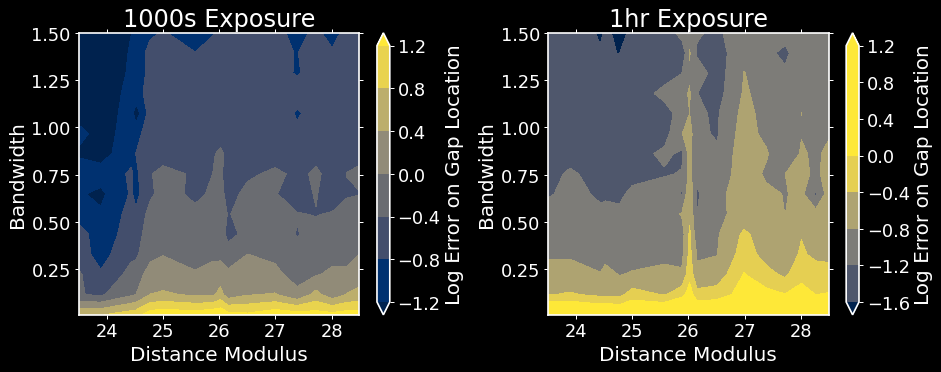

In [403]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
X, Y, Z= get_all_errors_on_location(5e6, galaxy, rgc, 27.15)
c= ax.contourf(Y,X, Z, cmap='cividis', extend='both')
plt.colorbar(c, label='Log Error on Gap Location', ax=ax)
ax.set(xlabel='Distance Modulus', ylabel='Bandwidth')

X, Y, Z= get_all_errors_on_location(5e6, galaxy, rgc, 28.54)
c= ax1.contourf(Y,X, Z, cmap='cividis',  extend='both', vmin=-2, vmax=0)
plt.colorbar(c, label='Log Error on Gap Location', ax=ax1)
ax1.set(xlabel='Distance Modulus', ylabel='Bandwidth')

ax.set(title='1000s Exposure')
ax1.set(title='1hr Exposure')
plt.tight_layout()

plt.savefig(path_plot+'/gaps_location_error_all_bws.jpeg')

In [276]:
(10**-0.75)*100

17.78279410038923